### The cost of error is very high. Let's call humans to *eliminate* it, but as humans are also expensive, let's use AI to make them as few as possible!!!

In this notebook, we will propose an artificial+human intelligence strategy to achieve 100% accuracy in the classification of normal and defective pieces generated by a casting process. 

The AI system will consist of an ensemble of convolutional neural networks. The use of an ensemble is absolutely necessary for the strategy to work, as we will discuss below.

In this way, we can achieve 100% classification accuracy using the minimum person-hour possible. This is important because, in this problem, the cost of a false positive or negative is very high. Therefore, pure AI systems, even with more than 99% accuracy, could be unacceptable in a real-world business environment.

The strategy was thought of as a solution for the issue proposed in [this discussion](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product/discussion/129717).

This text can be used as an introduction to computer vision and convolutional networks in the context of a problem with more practical appeal than the classical MNIST, for example.

If you find it useful, please upvote :)

In [1]:
import random
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics
import keras

print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(sns.__version__)
print(keras.__version__)

1.17.5
1.1.5
3.2.1
0.23.2
0.10.0
2.4.3


# The process and the data

The [dataset](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product), provided by [Pilot Technocast](http://www.pilottechnocast.com/), consists of images of regular and defective pieces from a casting process. In this process, the molten metallic material is fed into a mold and, during cooling, solidifies into the desired shape, as shown below:

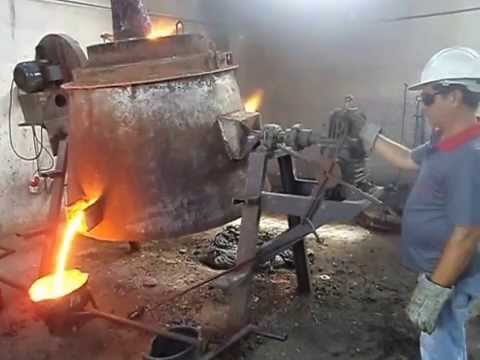

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("4Lo3tcrz8U0")

[Defects](https://en.wikipedia.org/wiki/Casting_defect) can be of different natures: gas porosity, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc. The following video, for example, provides tips to avoid the porosity problem:

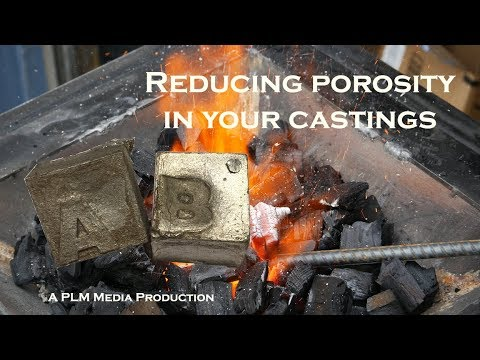

In [3]:
YouTubeVideo("OmmEXUnL4_8")

The pieces in question are [submersible pumps](https://en.wikipedia.org/wiki/Submersible_pump) impellers, whose operation is illustrated in the following video:

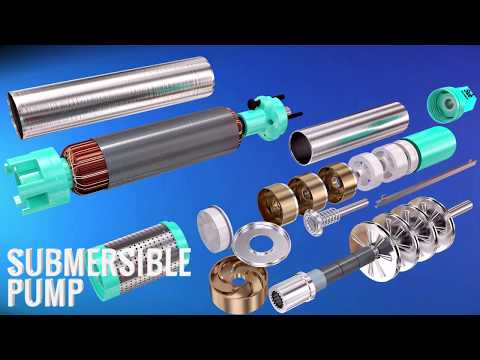

In [4]:
YouTubeVideo("L0Q6cboXyLY")

The dataset is organized in two directories, according to the structure:

    casting_data
    ├───test
    │   ├───def_front
    │   └───ok_front
    └───train
        ├───def_front
        └───ok_front
        
This structure is convenient because, at the time of reading by `keras`, the classes ` def_front` and `ok_front` are recognized according to the directories names.

In [5]:
technocast_PATH = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/'

technocast_train_path = technocast_PATH + 'train/'
technocast_test_path = technocast_PATH + 'test/'

Using `matplotlib` to take a look at two random pieces (normal and defective):

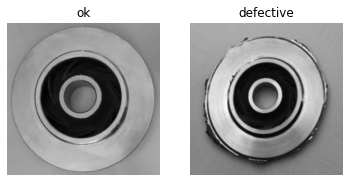

In [6]:
dir1 = technocast_train_path+'/ok_front/'
dir2 = technocast_train_path+'/def_front/'

img1 = plt.imread(dir1+random.choice(os.listdir(dir1)))
img2 = plt.imread(dir2+random.choice(os.listdir(dir2)))

fig, ax = plt.subplots(1,2)

ax[0].imshow(img1)
ax[0].axis('off')
ax[0].set_title('ok')

ax[1].imshow(img2)
ax[1].axis('off');
ax[1].set_title('defective');

Our models will need to distinguish these two types of images.

# Generating data with Keras


* Image files must be converted to tensors to be fed into neural networks (we will learn more about tensors below).
* We will use the class [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) (available in the module [keras.preprocessing.image](https://keras.io/api/preprocessing/image)) to generate the input tensors from the files availables in the `technocast_train_path` and` technocast_test_path` folders.

* This generation will take place in real time during training: at each iteration, a minibatch of tensors will be provided to the model so that a learning step can be carried out.

In the function below, we instantiate an object named `datagen` from the` ImageDataGenerator` class, specifying that the pixels will be normalized to the 0-1 range (by dividing by 255) and 10% of the data will be reserved for validation. After that, we use the `flow_from_directory` method to effectively create the objects that will generate the training and validation minibatches.

In [7]:
def make_generators():

    datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                           validation_split = 0.1)
    
    train_generator = datagen.flow_from_directory(directory = technocast_train_path, 
                                                  batch_size = 32,
                                                  target_size = (300, 300),
                                                  color_mode = "grayscale",
                                                  class_mode = "binary",
                                                  classes = {"ok_front": 0, "def_front": 1},
                                                  shuffle = True,
                                                  #seed = 0,
                                                  subset = "training")

    validation_generator = datagen.flow_from_directory(directory = technocast_train_path,
                                                       batch_size = 32,
                                                       target_size = (300, 300),
                                                       color_mode = "grayscale",
                                                       class_mode = "binary",
                                                       classes = {"ok_front": 0, "def_front": 1},
                                                       shuffle = True,
                                                       #seed = 0,
                                                       subset = "validation")
    
    return train_generator, validation_generator

The arguments of the `flow_from_directory` method specify that minibatches will be generated containing 32 grayscale images  (that is, with only 1 color channel) of shape 300x300. The classification problem is binary; the normal (`ok_front`) and defective (`def_front`) classes were assigned labels 0 and 1, respectively. The data will be shuffled and the seed of randomness has been specified as 0.

At this point, it is convenient to take a look at an example of a minibatch. For this, we will use the function `visualizeImageBatch`:

In [8]:
def visualizeImageBatch(datagen, title):
    
    '''
    Adapted from:
    https://www.kaggle.com/tomythoven/casting-inspection-with-data-augmentation-cnn
    '''
    
    mapping_class = {0: "0 (ok)", 1: "1 (defective)"}
    
    images, labels = next(iter(datagen))
    images = images.reshape(32, *(300,300))
    
    fig, axes = plt.subplots(4, 8, figsize=(13,6.5))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 12)

    fig.tight_layout()
    fig.suptitle(title, size = 16, y = 1.05)

Inspecting a manibatch:

Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.


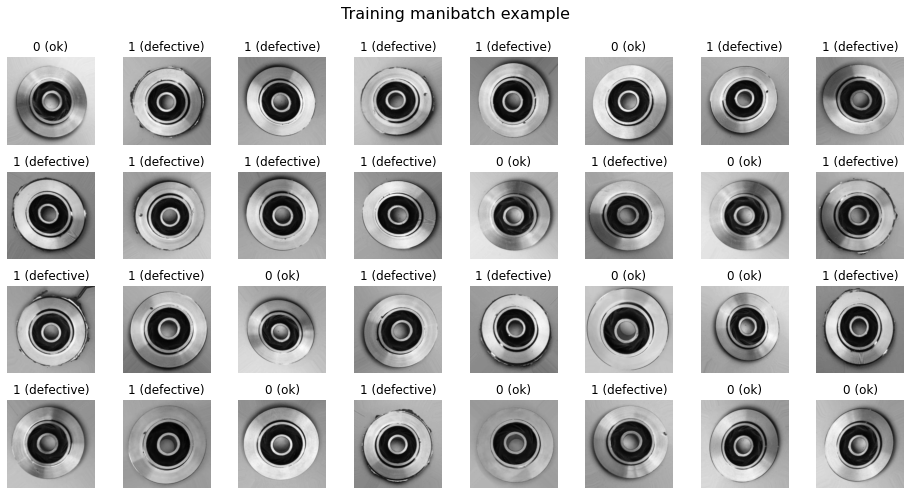

In [9]:
train_generator, validation_generator = make_generators()

visualizeImageBatch(train_generator, 'Training manibatch example')

Now let's create the test image generator, defined a bit differently:

In [10]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

n_test = sum([len(files) for r, d, files in os.walk(technocast_test_path)])

test_generator = test_datagen.flow_from_directory(directory = technocast_test_path,
                                                  batch_size = n_test,
                                                  target_size = (300, 300),
                                                  color_mode = "grayscale",
                                                  class_mode = "binary",
                                                  classes = {"ok_front": 0, "def_front": 1},
                                                  shuffle = False)

Found 715 images belonging to 2 classes.


We specified the minibatch size as the total size of the test set, since the test prediction will be made with all the data at once, after training ends.

It is useful to check the proportions of classes in the different sets:

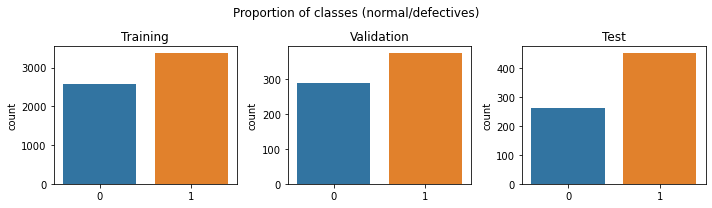

In [11]:
fig, ax = plt.subplots(1,3,figsize=(10,3))

sns.countplot(train_generator.classes,ax=ax[0])
sns.countplot(validation_generator.classes,ax=ax[1])
sns.countplot(test_generator.classes,ax=ax[2])

ax[0].set_title('Training')
ax[1].set_title('Validation')
ax[2].set_title('Test')

fig.suptitle('Proportion of classes (normal/defectives)')
fig.tight_layout(rect=[0, 0.03, 1, 0.92]);

The proportions seem consistent between sets. We could try to correct the prevalence of defective part images over normal ones, but as the difference is not so great, it will not be done.

Ok!! We already have the objects that will generate our training, validation and test data. Now let's proceed to the modeling phase.

# Convolutional networks

[Convolutional networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) are sparsely connected networks, where each neuron *does not* connect to all neurons in the previous layer. It is the opposite of densely connected networks, such as [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron).

Densely connected networks can only learn global patterns, that is, patterns that involve all points present in a given sample or observation. Convolutional networks, as we will see, are able to learn *local patterns* and recognize these patterns in *any position* of some other sample. In the case of images, these local patterns may correspond to borders, curves, etc.

Throughout the network structure, as we advance into deeper layers, simple local patterns are aggregated and become more and more complex. It is a learning structure analogous to that observed in the [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex), the brain portion responsible for the processing of visual information. That is why convolutional networks are so used to process images.

Mathematically, the network learns these local patterns through the [convolution](https://en.wikipedia.org/wiki/Convolution) operation, explained below.

## Operation of the convolutional network

* To feed an image to the network, it is necessary to represent it as a tensor. For example, the following is a representation of puppy image as a three-dimensional tensor of pixels:

<img src = "https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-47994-7_16/MediaObjects/472738_1_En_16_Fig2_HTML.png" width = "600" height = "600" />

* In this case, the resulting tensor has a 15x20x3 shape (that is, there are 15 rows, 20 columns and 3 color channels).

* Then the image goes through a *convolutional layer*. In this layer, the convolution operation is applied:

<img src = "https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-47994-7_16/MediaObjects/472738_1_En_16_Fig3_HTML.png" width = "500" height = "500" />

* In the convolution operation, a *filter* (also called a *kernel*), usually 3x3 (the most common), 5x5 or 7x7, runs through the pixels of an image computing the dot product at each step and storing the results in a matrix called *feature map*.

* The feature map gets its name because it is the structure responsible for recognizing the various patterns (features) related to the image. The nature of the recognized pattern depends on the structure of the filter.

* When the image has several channels, the feature map resulting from the filter is the sum of the feature maps corresponding to each channel.

* The convolutional layer can have several filters, each giving rise to a feature map.

* Each element of a feature map corresponds to a neuron. The neurons in the same feature map share the same parameters (weights).

* In general, the matrix that constitutes each filter of a given layer is a parameter of the network, that is, it is adjusted together with the weights in order to result in the optimal learning. The number of filters in a given layer is a hyperparameter (must be determined a priori).

* Multiple feature maps can be fed to a new convolutional layer, resulting in new maps, as illustrated:

<img src = "https://www.mdpi.com/sensors/sensors-19-01693/article_deploy/html/images/sensors-19-01693-g002-550.jpg" width = "400" height = "400 "/>

* Each neuron in an output feature map connects to only a portion of the neurons in the input maps. The portion of the previous layer that connects to a neuron is called its *receptive field*. The following figure illustrates well the concept of a neuron's receptive field:

<img src = "https://upload.wikimedia.org/wikipedia/commons/8/85/Convolution_arithmetic_-_Full_padding_no_strides_transposed.gif" width = "200" height = "200" />

* The convolution operation makes the output map smaller in shape than the input map. In order to make the shape the same, you can use *padding* strategies. In the following strategy, known as *zero padding* or *same padding*, zeros are added to the edges of the input map so that the output map has the same shape as the input. It is a way to preserve information from the edges along the network.

<img src = "https://upload.wikimedia.org/wikipedia/commons/8/80/Convolution_arithmetic_-_Same_padding_no_strides_transposed.gif" width = "200" height = "200" />

* If it is desired to generate output maps smaller than the input ones, *strides* can be used. In the following figure, the map is calculated with a stride of 2:

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c1/Convolution_arithmetic_-_Dilation.gif" width="200" height="200"/>

* Another strategy for generating output maps smaller than those of the input is the *expansion*, proposed by [YU and KOLTUN (2015)](https://arxiv.org/abs/1511.07122) and illustrated in the following figure. The advantage of dilation in relation to the stride strategy is the greater coverage of the receptive field of each neuron.

<img src = "https://upload.wikimedia.org/wikipedia/commons/c/c1/Convolution_arithmetic_-_Dilation.gif" width = "200" height = "200" />

* In addition to the convolutional layer, it is common to add *pooling* layers to the networks. Like convolutional layers, the neurons in pooling layers also have receptive fields, but there are no weights and the operation performed is not the convolution, but some aggregation operation, such as the average or the choice of the maximum value (the latter being the most used):

<img src="https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png
" width="350" height="350"/>

* In general, receptive pooling fields have shape 2x2 and stride 2, as shown above.

* The pooling layers reduce the number of network parameters, attenuating overfitting and computational cost. Furthermore, as information is aggregated from larger windows into smaller windows, the receptive fields of deeper layers, even though small, have information related to the entire original image. This makes it possible the recognition of global and more complex/abstract patterns in the deep layers.

* The following figure illustrates the typical architecture of a convolutional network:

<img src="https://www.researchgate.net/publication/336805909/figure/fig1/AS:817888827023360@1572011300751/Schematic-diagram-of-a-basic-convolutional-neural-network-CNN-architecture-26.ppm" width="500" height="500"/>

* The first part of the network performs *feature extraction*, that is, it identifies the various patterns present in the image. Typically, several pairs of convolution/pooling layers are used, which defines the depth of the network.

* The second part consists of a dense layer (fully connected, as in the MLP network) and is responsible for carrying out the classification.

* Some excellent pages for interactive views of convolutional networks are [this](https://www.cs.ryerson.ca/~aharley/vis/conv/) and [this](https://poloclub.github.io/cnn-explainer/).

Now we are going to implement an ensemble of convolutional networks in Keras.

# Generating an ensemble of networks

The strategy proposed here will be to create multiple networks and combine the various results in a single prediction. In general, creating a model consisting of multiple submodels is a procedure known as [ensembling](https://en.wikipedia.org/wiki/Ensemble_learning).

The motivation for using ensembling is the same as in the [random forest method](https://en.wikipedia.org/wiki/Random_forest): to reduce the generalization error. Statistics states that the greater the independence between the models, the greater the reduction in error. The differences between the networks in this case arise from the randomness of i) separation between training/validation and ii) initialization of weights.

The following function returns a compiled convolutional network:

In [12]:
def make_cnn():

    m = keras.models.Sequential([

    keras.layers.Conv2D(filters=16, kernel_size=(7,7), strides = 2, activation="relu", 
                        padding="same", input_shape=(300, 300, 1)),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation="relu"),

    keras.layers.Dropout(0.2),

    keras.layers.Dense(units=1, activation="sigmoid")

    ])

    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return m

Let's check the newtork's structure:

In [13]:
make_cnn().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       7

As usual, the feature maps sizes decrease and the number of filters increases as we advance in depth. Note that the first receptive field is larger than the others (7x7), which can be convenient to reduce the size of the image without losing a lot of information (and since there are generally only a maximum of 3 channels in the third dimension of the input, the operation is not so expensive).

Below we define a [callback](https://keras.io/api/callbacks/) for early stop. *Callbacks* are objects that perform actions during training. In the case below, the `early_stop` callback, defined from the [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) class, will monitor the loss of validation at each epoch and, if the decrease in last 5 epochs is no more than $10^{- 6}$, training will end.

In [14]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5)

We can train now. In the cell below, the various networks are trained in sequence. Note the presence of another callback, the `checkpoint`, instantiated from the [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) class and whose function is to save the best performing model (measured in relation to the loss of validation). This is useful because the result of last epoch is not necessarily the best.

In [15]:
%%time

# number of nets in the ensemble
n_models = 10

# lists that will store models and result histories
m = [0]*n_models
H = [0]*n_models

for i in range(n_models):

    print(f'Net {i+1}')
    print('----------------------------------------')
    
    # generating different training/validation sets for each train
    train_generator, validation_generator = make_generators()
    
    # generating the model
    m[i] = make_cnn()
    
    # checkpoint to save the best model for the network
    checkpoint = keras.callbacks.ModelCheckpoint(f"technocast_cnn_{i+1}.hdf5",
                                                 save_best_only = True,
                                                 monitor = "val_loss")
    
    print('Training...')
    
    # training the network
    H[i] = m[i].fit(train_generator, validation_data = validation_generator, 
                    epochs = 30, callbacks=[early_stop,checkpoint], verbose=0)
    
    # printing results after the training end
    epoch_min = pd.DataFrame(H[i].history).idxmin(axis=0)['val_loss']
    print(f"Epochs: {len(H[i].history['loss'])}") 
    print(f"loss: {H[i].history['loss'][epoch_min]:.4}, accuracy: {H[i].history['accuracy'][epoch_min]:.4}")
    print(f"val_loss: {H[i].history['val_loss'][epoch_min]:.4}, val_accuracy: {H[i].history['val_accuracy'][epoch_min]:.4}")
    print('----------------------------------------\n')

Net 1
----------------------------------------
Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Training...
Epochs: 14
loss: 0.05332, accuracy: 0.9836
val_loss: 0.03499, val_accuracy: 0.9909
----------------------------------------

Net 2
----------------------------------------
Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Training...
Epochs: 30
loss: 0.0152, accuracy: 0.9951
val_loss: 0.01498, val_accuracy: 0.997
----------------------------------------

Net 3
----------------------------------------
Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Training...
Epochs: 30
loss: 0.006183, accuracy: 0.998
val_loss: 0.01207, val_accuracy: 0.997
----------------------------------------

Net 4
----------------------------------------
Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Training...
Epochs: 21
loss: 0.01858, accuracy: 0.9955
val_loss: 0.0307,

# Analysis of results

Plotting the learning curves:

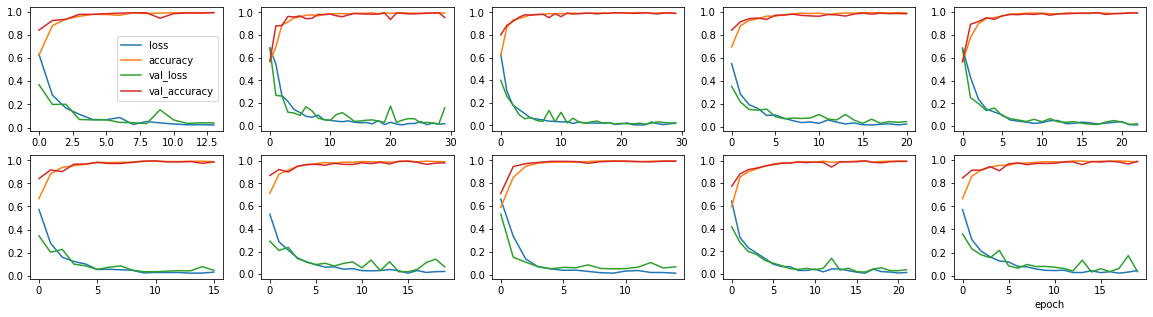

In [16]:
fig, ax = plt.subplots(2,5, figsize=(20,5))

for i in range(n_models):
    
    pd.DataFrame(H[i].history).plot(ax=ax.ravel()[i], legend = True if i==0 else False);
    plt.xlabel('epoch');

Loading the best settings for each model (saved by the `model_checkpoint` callback):

In [17]:
best_models = [keras.models.load_model(f"technocast_cnn_{i+1}.hdf5") for i in range(n_models)]

Defining a function to return the ensemble's prediction:

In [18]:
def ensemble_prediction(generator):
    
    y_probs = [best_models[i].predict(generator).squeeze() for i in range(len(best_models))]
    return np.mean(np.array(y_probs), axis=0)

Each network provides a probability for each image (that is, a number between $0$ and $1$). The closer the probability is to $0$, the more the network believes that the image belongs to class $0$; the closer to $1$, the more it believes the class is $1$.

In the function above, the probability of the ensemble is calculated as the average of the probabilities provided by each network.

In the next cell, we apply the function to calculate the probabilities for the test set:

In [19]:
y_probs = ensemble_prediction(test_generator)

To compute classification metrics, it is necessary to define which range of probabilities is associated with each class. In other words, it is necessary to choose the cut-off value that separates each of the two classes. The most intuitive way to do this is as follows:

* Class $0$: $ p \leq 0.5 $
* Class $1$: $ p> 0.5 $.

Although $0.5$ is the most common cut, we can vary this value in order to manipulate the proportions between [type I and type II errors](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors), as we will discuss in more detail later.

Calculating the metrics:

In [20]:
y = test_generator.classes
y_pred = y_probs>0.5

print(f'Accuracy:{sklearn.metrics.accuracy_score(y, y_pred):.4}')
print('------------------------------')
print('Confusion matrix:')
print(sklearn.metrics.confusion_matrix(y, y_pred))

Accuracy:1.0
------------------------------
Confusion matrix:
[[262   0]
 [  0 453]]


Two other metrics suitable for this problem are [$P$ (precision) and $R$ (recall)](https://en.wikipedia.org/wiki/Precision_and_recall). Denoting the negative class as being from normal samples (without defects) and the positive class as being from samples with defects, we define:

$$
P = \frac {VP} {VP + FP}
$$

$$
R = \frac {VP} {VP + FN}
$$

where $ P$ is the number of true positives, $FP$ is the number of false positives and $FN$ is the number of false negatives. In essence:

* Accuracy refers to the proportion of pieces detected as defective that is correct.
* Revocation refers to the proportion of defective pieces that are correctly detected.

Accuracy is a measure of the accuracy of detections and is all about *quality*; recall is a measure of completeness of detections and has to do with *quantity*. From the point of view of [hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing), precision is associated with type I errors and the recall is associated with type II errors.

An also widely used metric is [$F_1$](https://en.wikipedia.org/wiki/F1_score), the harmonic average between precision and recall:

$$F_1 = \frac{2}{1 / P + 1 / R}$$

In the next cell, we calculate the accuracy, recall and $F_1$ of our model:

In [21]:
print(f'Precision: {sklearn.metrics.precision_score(y, y_pred):.4}')
print(f'Recall: {sklearn.metrics.recall_score(y, y_pred):.4}')
print(f'F1: {sklearn.metrics.f1_score(y, y_pred):.4}')

Precision: 1.0
Recall: 1.0
F1: 1.0


There is a trade-off between precision and recall: when we increase one, the other tends to decrease. We can verify this trade-off by plotting the precision and recall curves as a function of the cut:

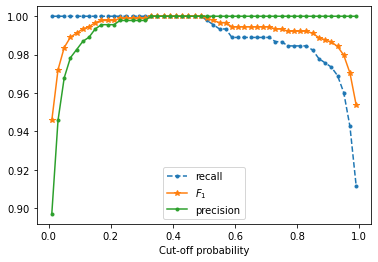

In [22]:
prob_x = np.linspace(0.01,0.99)

recall = [0]*len(prob_x)
f1 = [0]*len(prob_x)
precision = [0]*len(prob_x)

for i in range(len(prob_x)):
    y_pred_rp_curve = y_probs>prob_x[i]
    recall[i] = sklearn.metrics.recall_score(y, y_pred_rp_curve)
    f1[i] = sklearn.metrics.f1_score(y, y_pred_rp_curve)
    precision[i] = sklearn.metrics.precision_score(y, y_pred_rp_curve)

plt.plot(prob_x, recall,'.--')
plt.plot(prob_x, f1,'*-')
plt.plot(prob_x, precision,'.-')

plt.xlabel('Cut-off probability')
plt.legend(['recall','$F_1$','precision']);

The cut-off probability, therefore, can be a parameter defined according to the company's interest:

* If you want to minimize the loss caused by the waste of good pieces (ie, reduce the risk of false positives), you must select a cut that results in maximum precision.
* If you want to avoid sending defective parts to the customer as much as possible (that is, to reduce the risk of false negatives), you must select a cut that results in maximum recall.
* If you want a good compromise between the two scenarios described, you can select a cut that results in a maximum of $F_1$.

In the case of adjustment of this parameter, it is recommended to make the choice based on the validation data and not on the test data, so that we can use the test data to verify the suitability of the choice.

We have just understood the importance of the network's output probability for the classification process. In the next cells, this importance will become even clearer through a detailed analysis of the test set.

In the following figure, we depict all the 715 samples from the test set together with, respectively, the true class and the probability predicted by the model. In the case of mistaken predictions, the headings are in red.

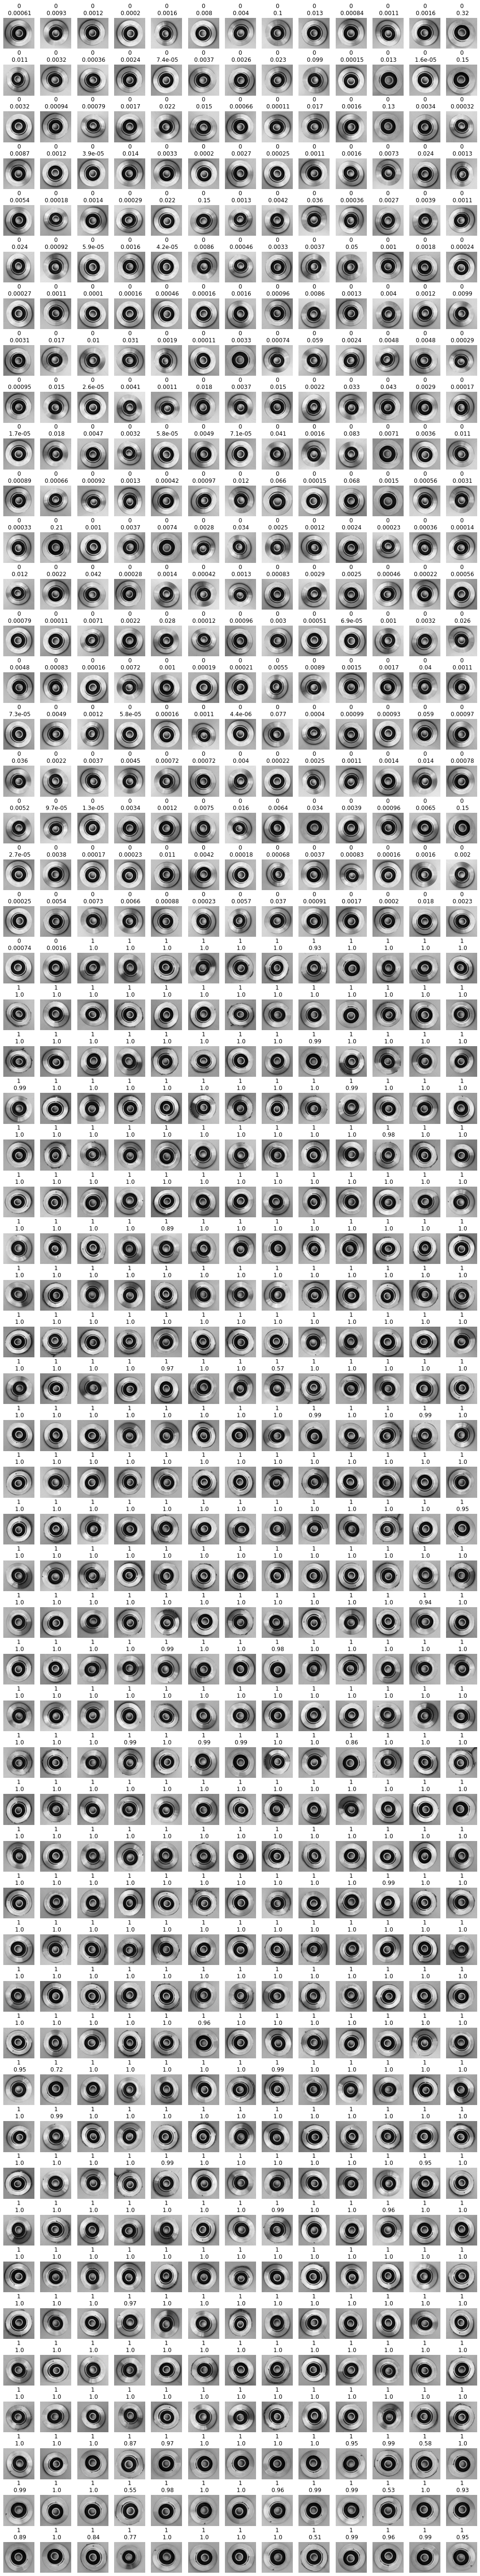

In [23]:
direc = technocast_test_path
imgs = [plt.imread(direc+file) for file in test_generator.filenames]

fig, ax = plt.subplots(715//13,13, figsize=(18,100))

for i in range(715):
    
    ax.ravel()[i].imshow(imgs[i])
    ax.ravel()[i].axis('off');
    
    color = ('black' if ((test_generator.labels[i]==0 and y_probs[i]<0.5)) or 
                        (test_generator.labels[i]==1 and y_probs[i]>=0.5) 
             else 'red')
    
    ax.ravel()[i].set_title(f'{test_generator.labels[i]}\n {y_probs[i]:.2}', color=color)

It is noticed that almost all of the predictions are close to 0 or 1, which indicates great certainty of the ensemble model regarding the classes of most images.

Looking only at the images classified incorrectly:

In [24]:
'''
In case the model reaches 100% accuracy, this cell will not run
'''

if sklearn.metrics.accuracy_score(y, y_pred)<1:

    direc = technocast_test_path

    # selecting images with wrong predictions

    wrong_positions = np.where(y!=y_pred)[0]
    wrong_files = [test_generator.filenames[i] for i in wrong_positions]

    imgs = [plt.imread(direc+file) for file in wrong_files]

    # probabilities for images with wrong predictions
    y_probs_wrong = ensemble_prediction((next(test_generator)[0][wrong_positions]))

    fig, ax = plt.subplots(1,len(wrong_positions), figsize = (20,5))

    # transforming ax, y_probs_wrong and wrong_positions objects into containers if they are not
    # so that we can enter the loop below even when there is only one wrong position
    ax = np.array([ax]) if not hasattr(type(ax), '__iter__') else ax
    y_probs_wrong = [y_probs_wrong] if not hasattr(type(y_probs_wrong), '__iter__') else y_probs_wrong
    wrong_positions = [wrong_positions] if not hasattr(type(wrong_positions), '__iter__')  else wrong_positions

    # plotting!

    for i in range(len(wrong_positions)):

        ax[i].imshow(imgs[i])
        ax[i].axis('off');
        ax[i].set_title(f'{test_generator.labels[wrong_positions[i]]}\n {y_probs_wrong[i]:.2}')
        ax[i].text(2, 15, str(wrong_positions[i]))

    fig.suptitle('Sample(s) incorrectly classified', fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.9]);

Samples with incorrect classifications mostly have predictions close to $0.5$. This fact can be used to build a strategy for reviewing the model's results. Predictions whose probabilities are very far from $0$ or $1$ (that is, in which the model is not very confident about the belonging to any of the classes) can be forwarded for human verification.

In the cell below, we select the samples that result in probabilities that are distant from $0$ or $1$ ('how far' can be an adjustable parameter):

In [25]:
'''
In case the model reaches 100% accuracy, this cell will not run
'''
if sklearn.metrics.accuracy_score(y, y_pred)<1:
    
    direc = technocast_test_path

    # selecting images with predictions away from 0 and 1

    mask = np.logical_and(y_probs > 0.2, y_probs < 0.8)

    unusual_prob_positions = np.where(mask)[0]
    unusual_prob_files = [test_generator.filenames[i] for i in unusual_prob_positions]

    imgs = [plt.imread(direc+file) for file in unusual_prob_files]

    # predictions themselves
    y_probs_unusual = ensemble_prediction(next(test_generator)[0][unusual_prob_positions])

    # generating the plot window

    n_columns = 5
    n_lines = max(1,max(1,len(unusual_prob_positions)//n_columns+1))

    fig, ax = plt.subplots(n_lines,n_columns, 
                           figsize = (20,4*n_lines))

    # turning all axes off before entering the loop
    [ax.ravel()[i].axis('off') for i in range(len(ax.ravel()))]

    # plotting!

    for i in range(len(unusual_prob_positions)):

        ax.ravel()[i].imshow(imgs[i])

        color = ('black' if ((test_generator.labels[unusual_prob_positions[i]]==0 and y_probs_unusual[i]<0.5)) or 
                            (test_generator.labels[unusual_prob_positions[i]]==1 and y_probs_unusual[i]>=0.5) 
                 else 'red')

        ax.ravel()[i].set_title(f'{test_generator.labels[unusual_prob_positions[i]]}\n {y_probs_unusual[i]:.2}',
                               color = color)

        ax.ravel()[i].text(2, 15, str(unusual_prob_positions[i]))

    suptitle1 = f'{len(unusual_prob_positions)} samples to be sent for human review ({(len(unusual_prob_positions)/715*100):.2}% of the total)'
    suptitle2 = f'of which {np.in1d(unusual_prob_positions, wrong_positions).sum()} classified incorrectly.'

    fig.suptitle(suptitle1+'\n'+suptitle2,fontsize=18);

    fig.tight_layout(rect=[0, 0.03, 1, 0.9])

Only a small fraction of the samples is in the range considered suspect (in the case above, 0.2 <p<0.8).

The use of an ensemble of nets increases the overall accuracy (reducing the samples in this range) and also helps to bring the averages of uncertain predictions close to 0.5 (which tends to bring images with incorrect classifications to that range). It is a favorable scenario for the implementation of a human revision strategy, resulting in a detection system that can reach 100% accuracy with low additional cost of [person-hour](https://en.wikipedia.org/wiki/Man-hour).

The review strategy is particularly important in this process because even low error rates (less than 1%) can result in considerable economic losses, since the cost of a single false positive or negative can be high (as discussed [here](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product/discussion/129717)).

If you run this notebook, you will probably get different results from the ones presented here, mainly regarding the number of incorrect classifications in the test set (which varies from 0 to 4, in general). But, in particular, I verified two consistent points throughout all the executions I made:

* the accuracy is higher than the recall over most of the cutoff probability range;
* the probabilities of the incorrectly classified samples are close to 0.5 (generally below, due to the recall being lower than precision).

Perhaps another strategy or architecture would lead to more stable results. You can try :)

# Ending

Thank you for reading! If you know portuguese, there is a lecture about this application in the following video:

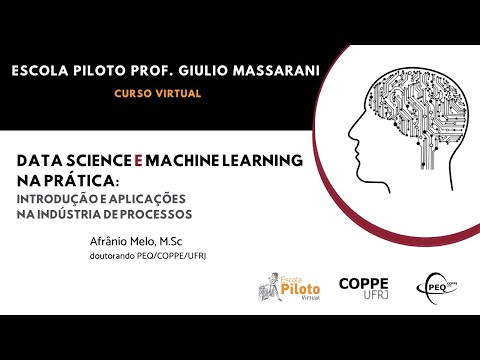

In [26]:
YouTubeVideo("cd-VSQeiPSM")